# ISMN data

Currently running in python 3.9(.11)

requirements:

pip intall ismn  
pip install Cartopy  
pip install matplotlib  
pip install numpy  

Resources:

Download ISMN data from: 
https://ismn.earth/en/

ISMN package documentation:
https://pypi.org/project/ismn/

Cartopy Documentation: 
https://scitools.org.uk/cartopy/docs/latest/





In [1]:
# Libraries
from ismn.interface import ISMN_Interface
import numpy as np
import matplotlib.pyplot as plt

# Global
%matplotlib inline

# Change to the directory where you have the ISMN zip downloaded.
data_path = (
    "../data/raw/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.zip"
)

In [2]:
# This will take a while the first time, while the interface creates all the indeces.
ismn_data = ISMN_Interface(data_path, parallel=True)

Found existing ismn metadata in ..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


In [11]:
# Hierarchical structure: ismn_data[network][station][sensor]
ismn_data["ARM"]["Anthony"]["STP-1-A_soil_temperature_0.000000_0.050000"].data

# Sensor name codes for variable and depth: _<variable>_<start/ m>_<end/ m>.  https://ismn.earth/en/data/metadata/

c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  return pd.read_csv(


,soil_temperature,soil_temperature_flag,soil_temperature_orig_flag
date_time,,,
2017-01-02 00:00:00,4.134180,G,M
2017-01-02 01:00:00,4.108790,G,M
2017-01-02 02:00:00,3.985600,G,M
2017-01-02 03:00:00,3.804640,G,M
2017-01-02 04:00:00,3.674370,G,M
...,...,...,...
2017-12-30 20:00:00,-0.637568,G,M
2017-12-30 21:00:00,-0.580889,G,M
2017-12-30 22:00:00,-0.520299,G,M


In [15]:
# Basic Query: select data by index and or metadata:

# Get the ids for the USCRN network and subset from the whole dataset.
ids = ismn_data.get_dataset_ids(
    variable="surface_temperature", filter_meta_dict={"network": "USCRN"}
)
uscrn_data = ismn_data.subset_from_ids(ids)

Found existing ismn metadata in ..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


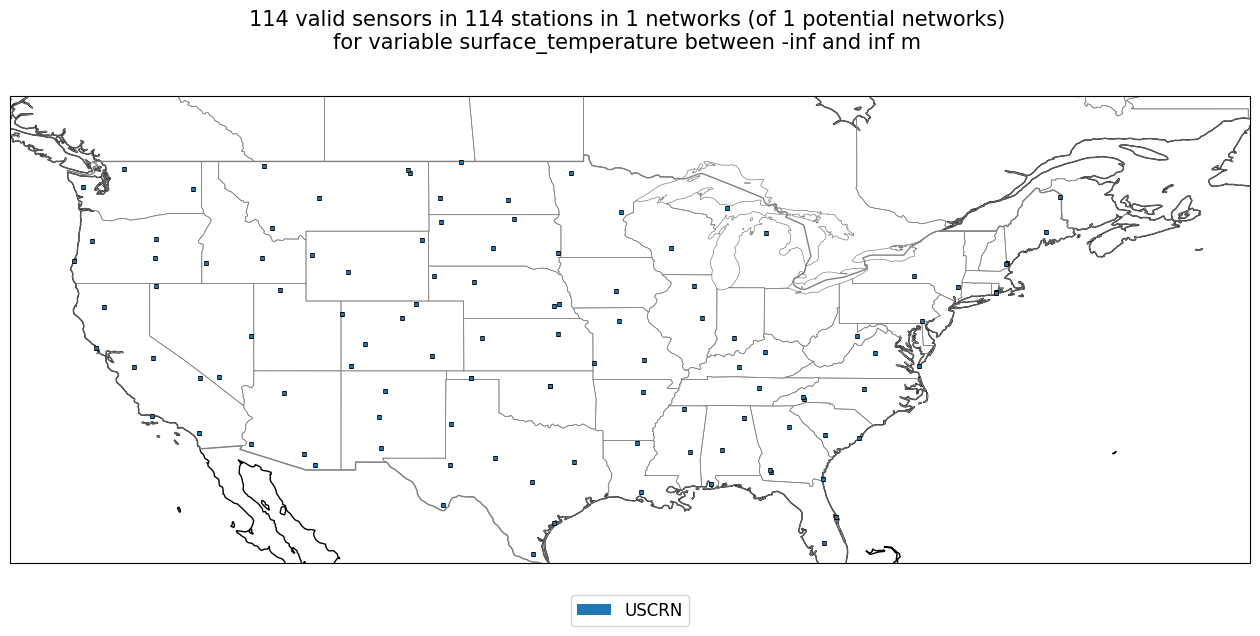

In [22]:
# Bonus: ismn has some nice compatibility with the cartopy package for plotting
import cartopy.crs as ccrs

# plot available station on a map
fig, ax = plt.subplots(
    1, 1, figsize=(16, 10), subplot_kw={"projection": ccrs.PlateCarree()}
)
uscrn_data.plot_station_locations(
    "surface_temperature", ax=ax, markersize=5, text_scalefactor=3
)
ax.set_extent([-128, -57, 26, 47])  # US aproximate coordinate range
plt.show()

In [16]:
# To recover the data from the sensors we iterate using the collectioniter_sensors()
valid_sensors = []
for network, station, sensor in uscrn_data.collection.iter_sensors(depth=[0, 0]):
    if (
        np.min(sensor.data["surface_temperature"]) > -100
    ):  # Some data will have badly recovered LST
        valid_sensors.append((network, station, sensor))

len(valid_sensors)

""" 
Unfortunatly, the ISMN package is old and not updated too often, so using some pandas versions will cause this FutureWarning to appear:

[...] venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated.
Combine the desired columns with pd.to_datetime after parsing instead.
return pd.read_csv(
  
"""

c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  return pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  return pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  return pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecate

37

In [18]:
# Extract ascending and descendig passes (6pm and 6am)

# Use the first sensor on the list as an example:
network, station, sensor = valid_sensors[0]

# This method returns a dataset for each sensor
timeseries = uscrn_data[network.name][station.name][sensor.name].data

# Filter by datetime index
ascending_ts = timeseries[timeseries.index.hour == 18]
descending_ts = timeseries[timeseries.index.hour == 6]

c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  return pd.read_csv(


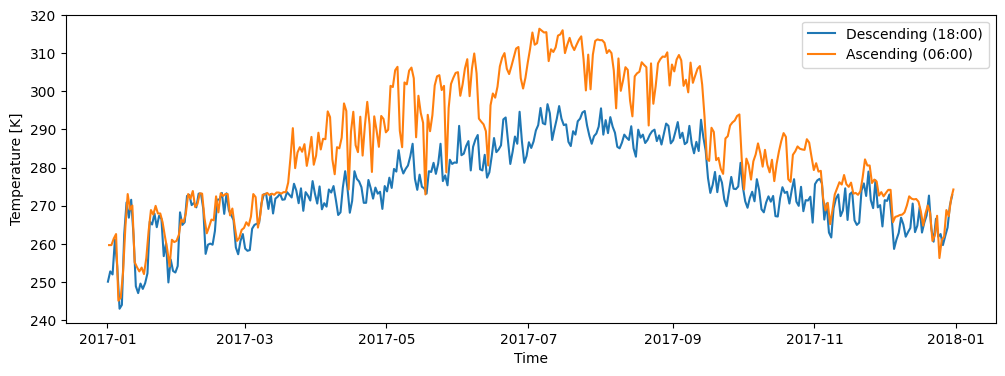

In [21]:
# Visualise 6pm-6am data from a station
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(descending_ts["surface_temperature"] + 273.15, label="Descending (18:00)")
ax.plot(ascending_ts["surface_temperature"] + 273.15, label="Ascending (06:00)")
ax.set_ylabel("Temperature [K]")
ax.set_xlabel("Time")
ax.legend()

plt.show()